In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import optuna
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from collections import Counter

from counterfactuals import get_counterfactuals, objective
from cost_functions import wachter2017_cost_function, weighted_watcher_cost_function
warnings.filterwarnings('ignore')

from prefrences import Feature, get_constant_weight_function, get_pow_weight_function

import scipy.stats

# Data reading and visualization

In [2]:
df = pd.read_csv('../datasets/adult.csv', na_values='?', index_col=0)
df.to_csv('adult.csv', index=False)
# drop rows with missing vals
df = df.dropna()
df = df.drop(columns = ['fnlwgt'])

### Description of the dataset

The "education-num" feature is a numerical representation of the "education" feature. Here is the mapping:

In [3]:
df = df.drop(columns = ['education'])

### Target class distribution

In [4]:
target = df.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Percentage=%.3f%%' % (k, per))

Class=<=50K, Percentage=75.216%
Class=>50K, Percentage=24.784%


### Select columns with numerical data types

In [5]:
num_ix = df.select_dtypes(include=['int64', 'float64']).columns
subset = df[num_ix]

In [6]:
subset.head()

,age,educational-num,capital-gain,capital-loss,hours-per-week
0,25,7,0,0,40
1,38,9,0,0,50
2,28,12,0,0,40
3,44,10,7688,0,40
5,34,6,0,0,30


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'educational-num'}>],
       [<AxesSubplot:title={'center':'capital-gain'}>,
        <AxesSubplot:title={'center':'capital-loss'}>],
       [<AxesSubplot:title={'center':'hours-per-week'}>, <AxesSubplot:>]],
      dtype=object)

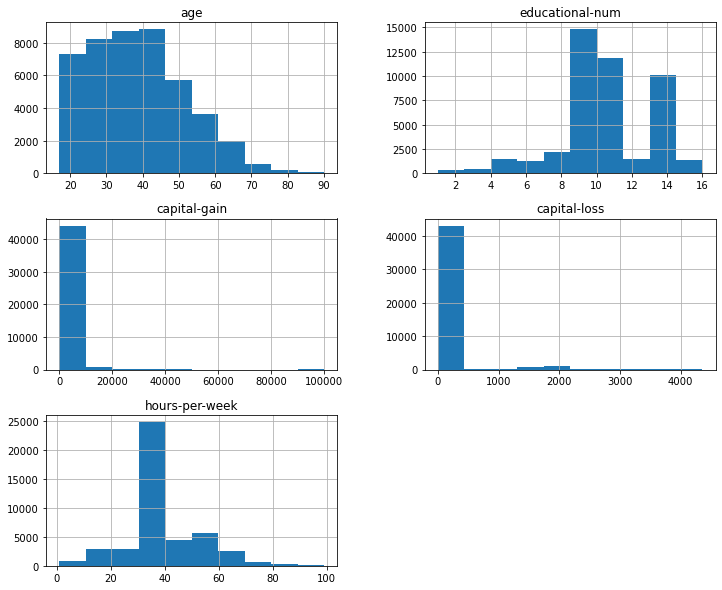

In [7]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca()
subset.hist(ax=ax)

### Train/Test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['income']), df['income'],
                                   random_state=42, 
                                   test_size=0.2, 
                                   shuffle=True)
y_label_encoder = LabelEncoder()
y_train = y_label_encoder.fit_transform(y_train)
y_test = y_label_encoder.transform(y_test)

In [9]:
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%s, Percentage=%.3f%%' % (k, per))

Class=1, Percentage=24.892%
Class=0, Percentage=75.108%


In [10]:
cat_ix = X_train.select_dtypes(include=['object', 'bool']).columns

### Model

In [11]:
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, verbose=1)

In [12]:
ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
# define the pipeline
pipeline = Pipeline(steps=[('t',ct), ('m',gbc)])

In [13]:
pipeline.fit(X_train,y_train)

      Iter       Train Loss   Remaining Time 
         1           1.0508            9.51s
         2           0.9970            9.62s
         3           0.9545            9.04s
         4           0.9188            8.76s
         5           0.8885            9.23s
         6           0.8637            8.96s
         7           0.8415            9.14s
         8           0.8229            9.10s
         9           0.8066            9.11s
        10           0.7916            9.19s
        20           0.7060            8.59s
        30           0.6653            8.10s
        40           0.6421            7.66s
        50           0.6280            7.15s
        60           0.6180            6.67s
        70           0.6100            6.18s
        80           0.6012            5.62s
        90           0.5961            5.10s
       100           0.5909            4.59s
       200           0.5636            0.00s


Pipeline(steps=[('t',
                 ColumnTransformer(transformers=[('c', OneHotEncoder(),
                                                  Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender', 'native-country'],
      dtype='object')),
                                                 ('n', MinMaxScaler(),
                                                  Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))])),
                ('m', GradientBoostingClassifier(n_estimators=200, verbose=1))])

In [14]:
x=X_test.iloc[9].values
x = x.reshape((1, -1))
sample_df = pd.DataFrame(x, columns=X_test.columns )

In [15]:
sample_df

,age,workclass,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,29,Private,10,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,20,United-States


In [16]:
pipeline.predict_proba(sample_df)

array([[0.90557878, 0.09442122]])

In [17]:
y_test[0]

0

y_test = 0 = fattig

### Model evaluation

In [229]:
X_test.head()

,age,workclass,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
21762,19,Self-emp-not-inc,6,Married-spouse-absent,Adm-clerical,Unmarried,Amer-Indian-Eskimo,Female,0,0,40,United-States
21701,45,Private,9,Married-civ-spouse,Farming-fishing,Husband,Amer-Indian-Eskimo,Male,0,0,40,United-States
42663,47,Private,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
42694,23,Private,10,Never-married,Craft-repair,Other-relative,White,Male,0,0,40,United-States
13590,53,Local-gov,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States


In [18]:
accuracy_score(pipeline.predict(X_test), y_test)

0.8727473742399116

In [19]:
accuracy_score(pipeline.predict(X_train), y_train)

0.8712165187826519

In [232]:
with open('pretrained_models/pipeline_adult.pkl','wb') as f:
    pickle.dump(pipeline,f)

In [20]:
pipeline.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [234]:
with open('pretrained_models/pipeline_adult.pkl', 'wb') as f:
    pickle.dump(pipeline, f)


#### F score

# User case 1

In [21]:
X_test.iloc[0]

age                                   19
workclass               Self-emp-not-inc
educational-num                        6
marital-status     Married-spouse-absent
occupation                  Adm-clerical
relationship                   Unmarried
race                  Amer-Indian-Eskimo
gender                            Female
capital-gain                           0
capital-loss                           0
hours-per-week                        40
native-country             United-States
Name: 21762, dtype: object

In [22]:
ashley = {'age': 30,
          'workclass': 'Self-emp-not-inc',
          'educational-num': 10,
          'marital-status': 'Never-married',
          'occupation': 'Sales', # so she is a cashier, or ndependent consultant for Oriflame
          'relationship': 'Own-child',
          'race': 'White',
          'gender': 'Female',
          'capital-gain': 0,
          'capital-loss': 0,
          'hours-per-week': 25,
          'native-country': 'United-States'}
ashley_df = pd.DataFrame(ashley, index=[0])

In [23]:
df.workclass.unique()

array(['Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay'], dtype=object)

In [24]:
pipeline.predict_proba(ashley_df)

array([[0.98821116, 0.01178884]])

So the Ashley is destined to be poor ?

In [25]:
ashley_df['workclass'] ='Self-emp-inc'
ashley_df['occupation'] ='Prof-specialty'
ashley_df['educational-num'] = 12
ashley_df['hours-per-week'] = 50
ashley_df['age'] = 32
ashley_df['gender'] = 'Female'
ashley_df['capital-gain']=5120 # 5119 is much less
ashley_df['marital-status'] = 'Married-AF-spouse'
ashley_df['relationship'] = 'Own-child'

In [26]:
pipeline.predict_proba(ashley_df)

array([[0.24363217, 0.75636783]])

In [33]:
X_test['native-country'].unique()

array(['United-States', 'Mexico', 'Vietnam', 'South', 'Germany',
       'Ecuador', 'Philippines', 'Columbia', 'Italy', 'England', 'Canada',
       'Dominican-Republic', 'China', 'Jamaica', 'Cambodia', 'Japan',
       'India', 'Poland', 'France', 'Cuba', 'Puerto-Rico', 'Taiwan',
       'Iran', 'Outlying-US(Guam-USVI-etc)', 'El-Salvador', 'Peru',
       'Ireland', 'Nicaragua', 'Greece', 'Trinadad&Tobago', 'Guatemala',
       'Haiti', 'Portugal', 'Laos', 'Yugoslavia', 'Scotland', 'Honduras',
       'Hong', 'Thailand', 'Hungary'], dtype=object)